In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 100
detector_params.filterByCircularity = False
detector = cv2.SimpleBlobDetector_create(detector_params)
eye_detector = cv2.SimpleBlobDetector_create(detector_params)


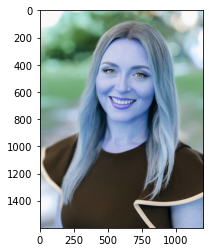

In [53]:
# img = cv2.imread('asian_female_headshot.jpg')
# img = cv2.imread('test-img.png')
# img = cv2.imread('headshot.jpeg')
# img = cv2.imread('black-man.jpeg')
img = cv2.imread('white-woman.jpeg')
plt.imshow(img)

In [54]:
from utils import detect_face_coords, detect_eyes_coords

face_coords = detect_face_coords(img, face_cascade)
fx, fy, fw, fh = face_coords
cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)

face_frame = img[fy : fy + fh, fx : fx + fw]
    
left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
lx, ly, lw, lh = left_eye_coords
rx, ry, rw, rh = right_eye_coords
cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
eye_frames = [left_eye_frame, right_eye_frame]

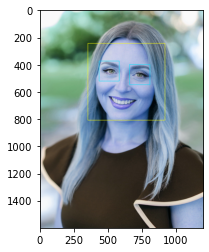

In [55]:
plt.imshow(img)

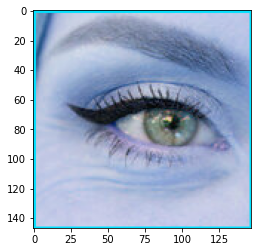

In [56]:
plt.imshow(eye_frames[0])

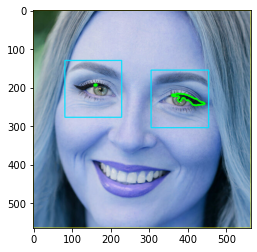

In [57]:
from utils import remove_eyebrows, find_eye_keypoints, find_best_threshold, shift_contour_inside_eye

for eye in eye_frames:
    eye = remove_eyebrows(eye)
    gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    
    threshold = find_best_threshold(gray_frame)
    _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1:] # removes the window frame contour
    contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
    
#     largest_contour = contours[0]
#     largest_contour = shift_contour_inside_eye(eye, largest_contour)
#     contours[0] = largest_contour

    cv2.drawContours(eye, contours, 0, (0,255,0), 3)

plt.imshow(face_frame)

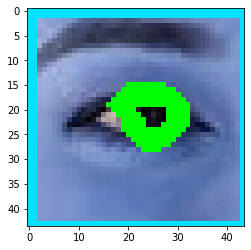

In [18]:
plt.imshow(eye_frames[0])

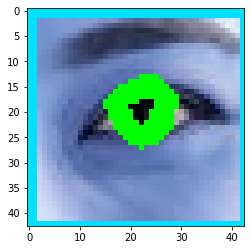

In [19]:
plt.imshow(eye_frames[1])

In [12]:
cap = cv2.VideoCapture(0)
while True:
    _, frame = cap.read()
    face_coords = detect_face_coords(frame, face_cascade)
    fx, fy, fw, fh = face_coords
    if np.sum(face_coords) > 0:
        
        cv2.rectangle(frame, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)
        face_frame = frame[fy : fy + fh, fx : fx + fw]

        left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
        lx, ly, lw, lh = left_eye_coords
        rx, ry, rw, rh = right_eye_coords
        if np.sum(left_eye_coords) > 0 and np.sum(right_eye_coords) > 0:
            cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
            cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

            left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
            right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
            eye_frames = [left_eye_frame, right_eye_frame]

            for eye in eye_frames:
                eye = remove_eyebrows(eye)
                gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
                gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

                threshold = find_best_threshold(gray_frame)
                _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contours = contours[1:] # removes the window frame contour
                contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

                if contours:
                    cv2.drawContours(eye, contours, 0, (0,255,0), 3)
        
        cv2.imshow('Iris Detection', frame[fy : fy + fh, fx : fx + fw])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()